Импортим библиотеки

In [2]:
import csv
import sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install telethon
!apt-get update
!apt-get install -y chromium-chromedriver
!pip install selenium
!pip install streamlit pyngrok wordcloud
!pip install webdriver-manager
from telethon.sync import TelegramClient
from telethon.tl.types import Message
import asyncio
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.9/715.9 kB 12.0 MB/s eta 0:00:00
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26346 sha256=7358a531f28fef501f1eb7c7dfb6ab8c0f8c73792b185031cfb5e22786a2f915
  Stored in directory: /root/.cache/pip/wheels/4e/52/33/010d0843550bffb6a591b11629070ae140c0ad4f53e68a3bd3
Successfully built pyaes
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,763 

Функция для выгрузки данных из телеграмм каналов

In [3]:
async def export_channel_posts(channel_username, api_id, api_hash, csv_filename='posts.csv'):
    async with TelegramClient('session_name', api_id, api_hash) as client:
        posts = []

        async for message in client.iter_messages(channel_username):
            if isinstance(message, Message) and message.message:
                posts.append([message.id, message.date.strftime("%Y-%m-%d %H:%M:%S"), message.message])

        with open(csv_filename, 'w', encoding='utf-8', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['id', 'date', 'text'])
            writer.writerows(posts)

Выгружаем данные

In [4]:
channels=['https://t.me/infomoscow24', 'https://t.me/mos_sobyanin', 'https://t.me/interfaxonline']

In [5]:
API_ID=''
API_HASH=''

In [5]:
for i in range(2,len(channels)):
  await export_channel_posts(channels[i],API_ID,API_HASH,str(i)+'posts.csv')

Please enter your phone (or bot token): +79859644955
Please enter the code you received: 51866
Please enter your password: ··········
Signed in successfully as Kirill Dolgopol; remember to not break the ToS or you will risk an account ban!


Оставляем только новости, касающиеся парковок

In [18]:
def filter_csv_files(filenames, new_filename, filter_str):
    import pandas as pd
    filtered_dfs = []
    for file in filenames:
        df = pd.read_csv(file)
        mask = df.iloc[:, 2].str.contains(filter_str, case=False, na=False)
        filtered_dfs.append(df[mask])
    result_df = pd.concat(filtered_dfs, ignore_index=True)
    result_df.to_csv(new_filename, index=False, encoding="utf-8-sig")

In [19]:
filenames = ["0posts.csv", "1posts.csv", "2posts.csv"]

In [21]:
filter_csv_files(filenames,'parkovki.csv',r"парковоч|парковк")

Теперь смотрим еслть ли там где-то что-то связанное с сервисом, приложением и тд

In [22]:
filenames = ["parkovki.csv"]

In [23]:
filter_csv_files(filenames,'servisi.csv',r"сервис|прилож")

Теперь смотрим что-то про свободные места

In [24]:
filenames = ["servisi.csv"]

In [25]:
filter_csv_files(filenames,'mesta.csv',r"свобод|пуст|занят")

Ручным просмотром новостей находим потенциальных конкурентов: сервисы "Парковки России" и "Электронный дом"

Смотрим все объявления с этими сервисами в разделе парковки

In [26]:
filter_csv_files(['parkovki.csv'],'parkovkirossii.csv',r"Парковки России|парковки России")

In [27]:
filter_csv_files(['parkovki.csv'],'elecdom.csv',r"Электронный дом|электронный дом|Электронный Дом")

Строим график популярности темы парковок

<ipython-input-41-ef8689b0b0bf>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df.groupby(pd.Grouper(key=df.columns[1], freq='M')).size()


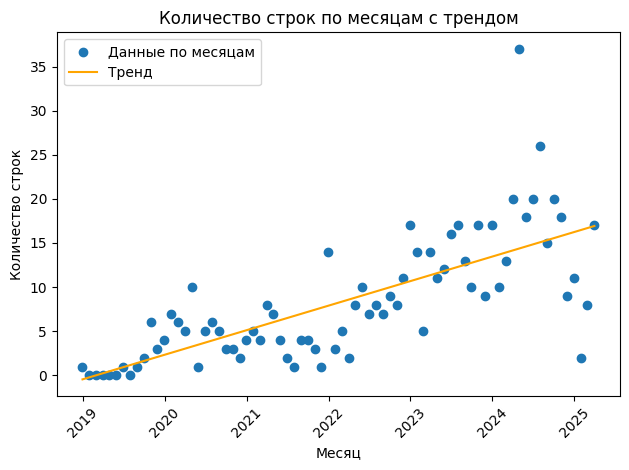

In [41]:
df = pd.read_csv('parkovki.csv')

df[df.columns[1]] = pd.to_datetime(df[df.columns[1]], format='%Y-%m-%d %H:%M:%S')

df = df.sort_values(by=df.columns[1])

grouped = df.groupby(pd.Grouper(key=df.columns[1], freq='M')).size()

dates = grouped.index
counts = grouped.values

x_ordinal = dates.map(pd.Timestamp.toordinal)

plt.scatter(dates, counts, label='Данные по месяцам')

coefs = np.polyfit(x_ordinal, counts, 1)
trend_func = np.poly1d(coefs)
plt.plot(dates, trend_func(x_ordinal), color='orange', label='Тренд')

plt.xlabel('Месяц')
plt.ylabel('Количество строк')
plt.title('Количество строк по месяцам с трендом')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-44-cc432c962d38>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped_park = df_park.groupby(pd.Grouper(key=df_park.columns[1], freq='M')).size()
<ipython-input-44-cc432c962d38>:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped_posts = df_posts.groupby(pd.Grouper(key=df_posts.columns[1], freq='M')).size()
<ipython-input-44-cc432c962d38>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_me

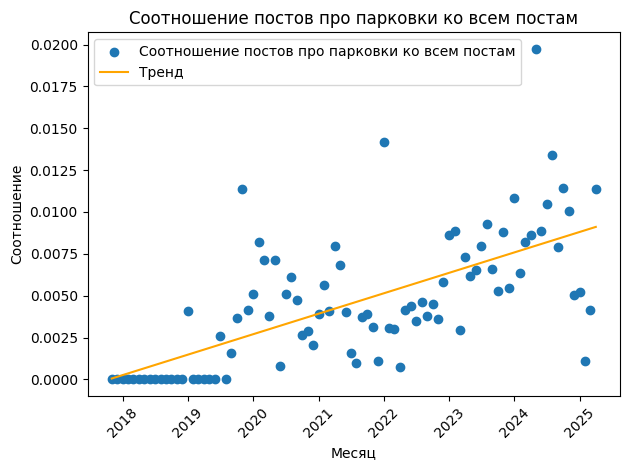

In [44]:
df_park = pd.read_csv('parkovki.csv')

df_park[df_park.columns[1]] = pd.to_datetime(
    df_park[df_park.columns[1]],
    format='%Y-%m-%d %H:%M:%S'
)

grouped_park = df_park.groupby(pd.Grouper(key=df_park.columns[1], freq='M')).size()
grouped_park.index.name = 'month'
grouped_park.name = 'parkovki_count'


files = ['0posts.csv', '1posts.csv', '2posts.csv']
dfs_posts = []
for f in files:
    temp_df = pd.read_csv(f)
    temp_df[temp_df.columns[1]] = pd.to_datetime(
        temp_df[temp_df.columns[1]],
        format='%Y-%m-%d %H:%M:%S'
    )
    dfs_posts.append(temp_df)

df_posts = pd.concat(dfs_posts, ignore_index=True)

grouped_posts = df_posts.groupby(pd.Grouper(key=df_posts.columns[1], freq='M')).size()
grouped_posts.index.name = 'month'
grouped_posts.name = 'posts_count'



df_merged = pd.merge(
    grouped_park.reset_index(),
    grouped_posts.reset_index(),
    how='outer',
    on='month'
).fillna(0)

df_merged = df_merged.sort_values(by='month')

df_merged['ratio'] = df_merged['parkovki_count'] / df_merged['posts_count'].replace(0, np.nan)

df_merged['ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged['ratio'].fillna(0, inplace=True)

months = df_merged['month']
ratio = df_merged['ratio']

plt.scatter(months, ratio, label='Соотношение постов про парковки ко всем постам')

x_ordinal = months.map(pd.Timestamp.toordinal).values
coefs = np.polyfit(x_ordinal, ratio, 1)
trend_func = np.poly1d(coefs)
plt.plot(months, trend_func(x_ordinal), color='orange', label='Тренд')

plt.xlabel('Месяц')
plt.ylabel('Соотношение')
plt.title('Соотношение постов про парковки ко всем постам')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
df_park = pd.read_csv('parkovki.csv')

if len(df_park.columns) < 3:
    raise ValueError("В parkovki.csv меньше трёх столбцов! Нужен хотя бы 3-й столбец с текстом.")

text_column = df_park.columns[2]
all_texts = ' '.join(str(t) for t in df_park[text_column] if pd.notnull(t))

stopwords = {
    "и","а","но","как","что","это","так","также","похожих",
    "на","в","из","у","к","о","об","от","с","со","при","по","за","под","над",

}

words = all_texts.split()
filtered_words = []

for w in words:
    w_lower = w.lower()
    if len(w) >= 4 and "подпи" not in w_lower and w_lower not in stopwords:
        filtered_words.append(w)

filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()

NameError: name 'pd' is not defined